In [2]:
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
import torch_geometric as pyg 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import pickle as pkl 
from sklearn.metrics import r2_score
from adjustText import adjust_text
import os 
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import gseapy
import statsmodels.formula.api as sm

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset
from src.interpret.model_comparison_utils import plot_model2model_comparison, grouped_performance

%load_ext autoreload
%autoreload 2

In [3]:
gsnn_root = '../output/from_exacloud/exp1/GSNN/'
nn_root = '../output/from_exacloud/exp1/NN/'
gsnn_rand_root = '../output/from_exacloud/exp1/GSNN_RAND/'

data_path = '../output/from_exacloud/exp1/proc/'
out_path = '../output/from_exacloud/exp1/'

In [4]:
gsnn_models = [torch.load(gsnn_root + '/' + fold + '/' + os.listdir(gsnn_root + '/' + fold)[0]) for fold in os.listdir(gsnn_root)]
nn_models = [torch.load(nn_root + '/' + fold + '/' + os.listdir(nn_root + '/' + fold)[0]) for fold in os.listdir(nn_root)]
gsnn_rand_models = [torch.load(gsnn_rand_root + '/' + fold + '/' + os.listdir(gsnn_rand_root + '/' + fold)[0]) for fold in os.listdir(gsnn_rand_root)]

print('# GSNN models', len(gsnn_models))
#print('# NN models', len(nn_models))
print('# GSNN (rand) models', len(gsnn_rand_models))

# GSNN models 3
# GSNN (rand) models 3


In [5]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)
siginfo.head(3)

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0


In [6]:
data = torch.load(data_path + '/Data.pt')
#all_ids = np.load(data_path + '/lincs_train_obs.npy', allow_pickle=True).tolist() + np.load(data_path + '/lincs_test_obs.npy', allow_pickle=True).tolist() + np.load(data_path + '/lincs_val_obs.npy', allow_pickle=True).tolist()
sig_ids = np.load(data_path + '/sig_ids.npy', allow_pickle=True).tolist()
dataset = LincsDataset(data_path, sig_ids, data, null_inflation=0.)
loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False, num_workers=8)

In [7]:
if False: 

    gsnn_rand_predictions = []
    for gsnn in gsnn_rand_models: 
        y, yhat, sig_ids = utils.predict_gsnn(loader, gsnn, data, device='cuda', return_omics=False)
        gsnn_rand_predictions.append({'y':y, 'yhat':yhat, 'sig_ids':sig_ids})

    gsnn_predictions = []
    for gsnn in gsnn_models: 
        y, yhat, sig_ids = utils.predict_gsnn(loader, gsnn, data, device='cuda', return_omics=False)
        gsnn_predictions.append({'y':y, 'yhat':yhat, 'sig_ids':sig_ids})

    nn_predictions = []
    for nn in nn_models: 
        y, yhat, sig_ids = utils.predict_nn(loader, nn.cuda(), data, device='cuda')
        nn_predictions.append({'y':y, 'yhat':yhat, 'sig_ids':sig_ids})

    with open(out_path + '/gsnn_predictions.pkl', 'wb') as f: 
        pkl.dump(gsnn_predictions, f)

    with open(out_path + '/nn_predictions.pkl', 'wb') as f: 
        pkl.dump(nn_predictions, f)

    with open(out_path + '/gsnn_rand_predictions.pkl', 'wb') as f: 
        pkl.dump(gsnn_rand_predictions, f)

else: 
    with open(out_path + '/gsnn_predictions.pkl', 'rb') as f: 
        gsnn_predictions = pkl.load(f)

    with open(out_path + '/nn_predictions.pkl', 'rb') as f: 
        nn_predictions = pkl.load(f)

    with open(out_path + '/gsnn_rand_predictions.pkl', 'rb') as f: 
        gsnn_rand_predictions = pkl.load(f)



siginfo2 = pd.DataFrame({'sig_id':sig_ids}).merge(siginfo, on='sig_id', how='left').reset_index()



# Performance by `drug`

In [8]:
drug_dict = {p:siginfo2[lambda x: x.pert_id == p].index.values for p in siginfo2.pert_id.unique()}

drug_res = grouped_performance(drug_dict, gsnn_predictions, nn_predictions, min_members_per_group=100)
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')
drug_res = drug_res.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='group', right_on='pert_id', how='left')

computing row-wise groups
progress: 512/513
# failed groups (too few obs per group): 393


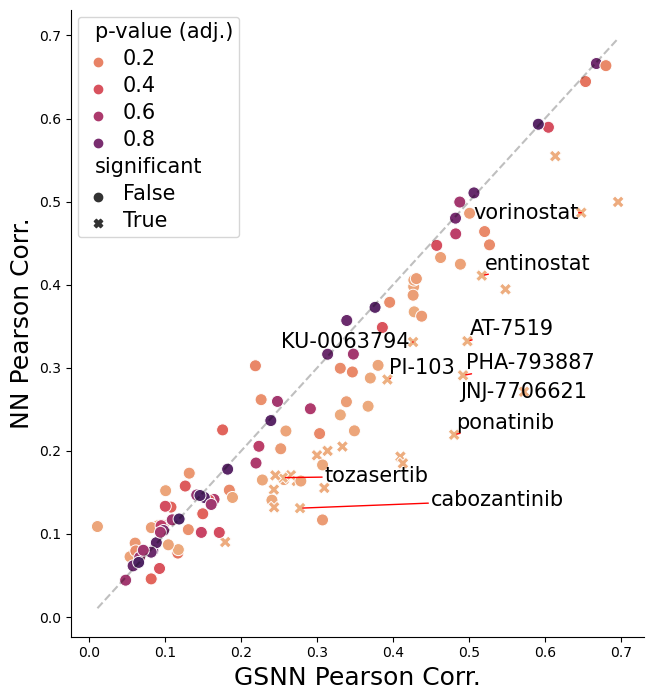

In [9]:
plot_model2model_comparison(drug_res, 'cmap_name', 10, fontsize=15, markersize=75)

computing row-wise groups
progress: 512/513
# failed groups (too few obs per group): 393


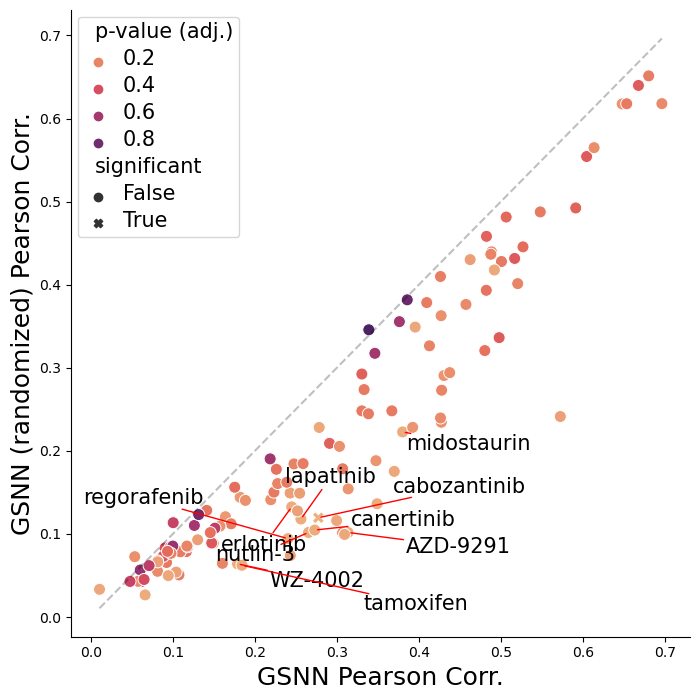

In [10]:
drug_res_rand = grouped_performance(drug_dict, gsnn_predictions, gsnn_rand_predictions, min_members_per_group=100)
drug_res_rand = drug_res_rand.merge(druginfo[['pert_id', 'cmap_name']].drop_duplicates(), left_on='group', right_on='pert_id', how='left')
plot_model2model_comparison(drug_res_rand, 'cmap_name', 10, model2_name='GSNN (randomized)')

In [11]:
drug_res.sort_values('mean_diff_r', ascending=False).tail(25)

,group,gsnn_mean_r,nn_mean_r,gsnn_std_r,nn_std_r,pval,tstat,mean_diff_r,std_diff_r,ci_diff_r,N_members,pval_adj,pert_id,cmap_name
24,BRD-K74514084,0.141350,0.146896,0.006197,0.007368,0.583658,-0.647593,-0.005546,0.012111,"[-0.021404636825206456, 0.003843347122854801]",240,0.686656,BRD-K74514084,pazopanib
70,BRD-A91452556,0.066197,0.071821,0.005016,0.010041,0.559360,-0.694186,-0.005624,0.011458,"[-0.019713491225659102, 0.006738065075085506]",145,0.664586,BRD-A91452556,estradiol-cypionate
115,BRD-K97963946,0.097697,0.104152,0.009149,0.011843,0.672578,-0.490058,-0.006456,0.018630,"[-0.030667922865257508, 0.010002711652533318]",115,0.783586,BRD-K97963946,EMD-1214063
86,BRD-K53414658,0.109131,0.117030,0.028597,0.038459,0.495073,-0.827279,-0.007900,0.013504,"[-0.024889133339282186, 0.0059375160477590175]",179,0.634092,BRD-K53414658,tivozanib
117,BRD-K62734952,0.093564,0.102057,0.016943,0.005153,0.505194,-0.805246,-0.008493,0.014916,"[-0.027590307038335732, 0.005909441504807276]",119,0.634784,BRD-K62734952,arglabin
105,BRD-K74065929,0.071050,0.080392,0.013630,0.004598,0.541237,-0.730158,-0.009342,0.018094,"[-0.02448685528715181, 0.014284392585924162]",128,0.649485,BRD-K74065929,doramapimod
33,BRD-K12343256,0.487803,0.499499,0.011126,0.023640,0.514204,-0.785998,-0.011696,0.021044,"[-0.03921367667305631, 0.005466934337695622]",263,0.636129,BRD-K12343256,trametinib
29,BRD-K19540840,0.247707,0.259537,0.015661,0.018139,0.496706,-0.823693,-0.011830,0.020311,"[-0.038404843649507796, 0.0026447582771801743]",206,0.634092,BRD-K19540840,saracatinib
73,BRD-K11267252,0.097042,0.110432,0.009442,0.003644,0.147619,-2.305218,-0.013390,0.008215,"[-0.02199485318738692, -0.0031448761526632115]",226,0.249497,BRD-K11267252,alectinib
101,BRD-K49075727,0.094474,0.109954,0.021136,0.029085,0.383403,-1.107613,-0.015480,0.019765,"[-0.04126792737534349, 0.0012541465499789125]",103,0.528831,BRD-K49075727,nintedanib


# performance by `drug target`

computing row-wise groups
progress: 133/134
# failed groups (too few obs per group): 25


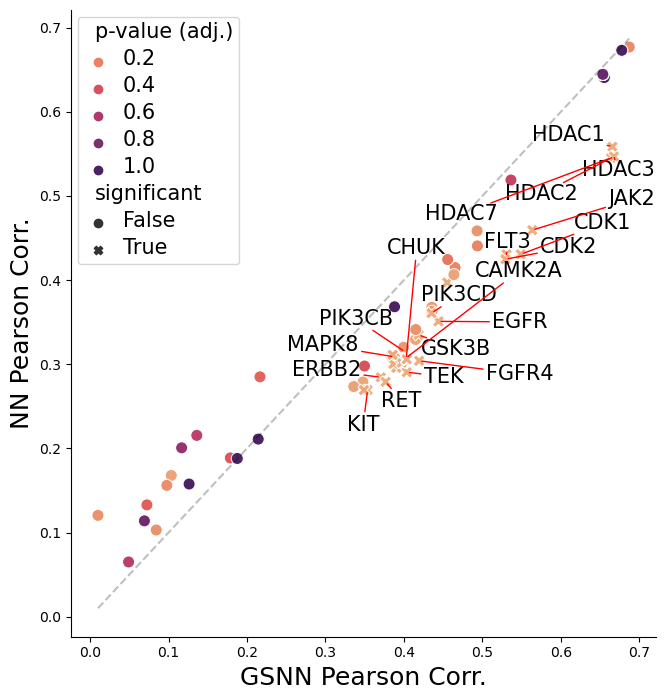

In [12]:
src,dst = data.node_names[data.edge_index]
drug_targ = pd.DataFrame({'src':src, 'dst':dst})[lambda x: x.src.str.contains('DRUG__')]
drug_targ = drug_targ.assign(pert_id = [x.split('__')[1] for x in drug_targ.src.values], 
                             uniprot = [x.split('__')[1] for x in drug_targ.dst.values])
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
drug_targ = drug_targ.merge(uni2symb, on='uniprot', how='left')

targ_dict = {}
targspace = drug_targ.uniprot.unique()
for i,targ in enumerate(targspace): 
    drugs_with_targ = drug_targ[lambda x: x.uniprot == targ].pert_id.unique().tolist()
    idx = siginfo2[lambda x: x.pert_id.isin(drugs_with_targ)].index
    targ_dict[targ] = idx 

targ_res = grouped_performance(targ_dict, gsnn_predictions, nn_predictions, pval_adj_method='fdr_by', min_members_per_group=100)
targ_res = targ_res.merge(uni2symb, left_on='group', right_on='uniprot', how='left')
plot_model2model_comparison(targ_res, 'gene_symbol', 20, adjust_labels=True)

computing row-wise groups
progress: 133/134
# failed groups (too few obs per group): 25


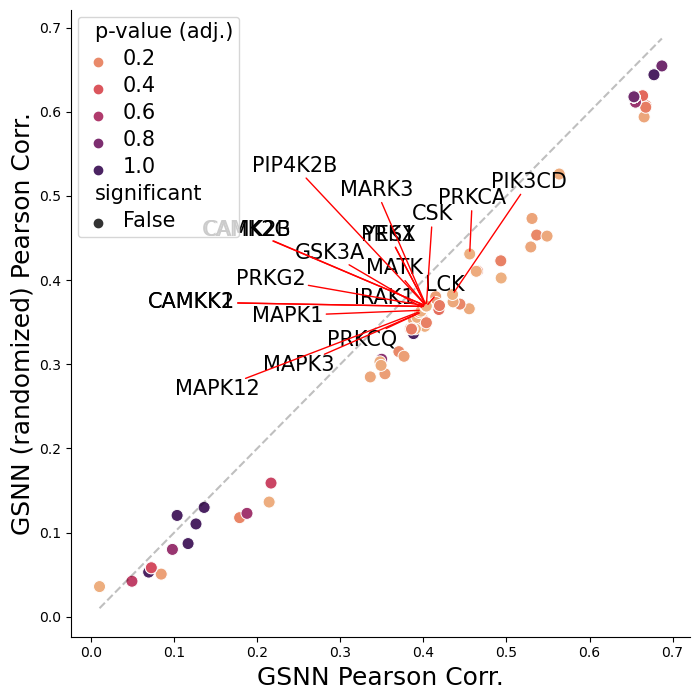

In [13]:
targ_res_rand = grouped_performance(targ_dict, gsnn_predictions, gsnn_rand_predictions, pval_adj_method='fdr_by', min_members_per_group=100)
targ_res_rand = targ_res_rand.merge(uni2symb, left_on='group', right_on='uniprot', how='left')
plot_model2model_comparison(targ_res_rand, 'gene_symbol', 20, adjust_labels=True, model2_name='GSNN (randomized)')

In [14]:
# for gsea 
targ_res[['gene_symbol', 'tstat']].to_csv(out_path + '/targ_res_gene_list.csv', index=False, header=False, sep='\t')

# performance by `gene`

computing column-wise groups
progress: 452/453
# failed groups (too few obs per group): 0


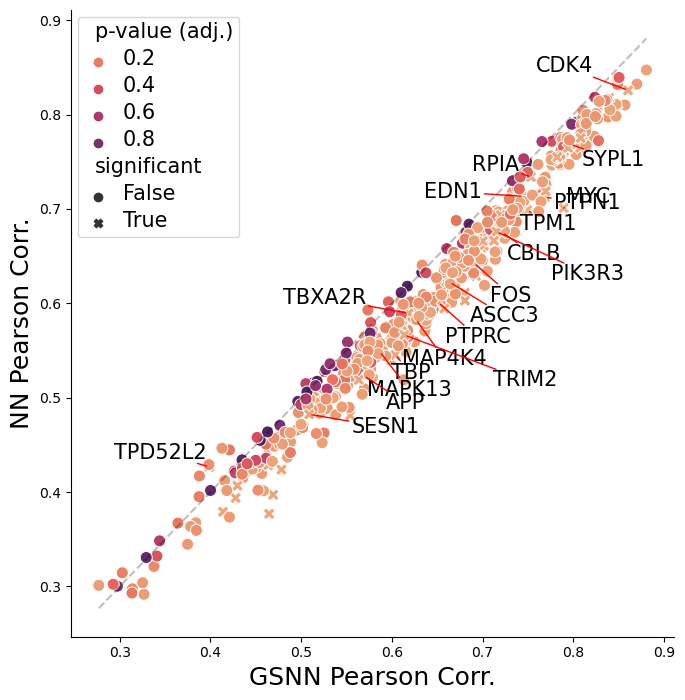

In [15]:
gene_res = grouped_performance({gene:[i] for i,gene in enumerate(data.node_names[data.output_node_mask])}, gsnn_predictions, nn_predictions, axis=1, pval_adj_method='fdr_bh', min_members_per_group=0)
gene_res = gene_res.assign(uniprot = [x.split('__')[1] for x in gene_res.group.values])
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
gene_res = gene_res.merge(uni2symb, on='uniprot', how='left')

plot_model2model_comparison(gene_res, 'gene_symbol', 20)

computing column-wise groups
progress: 452/453
# failed groups (too few obs per group): 0


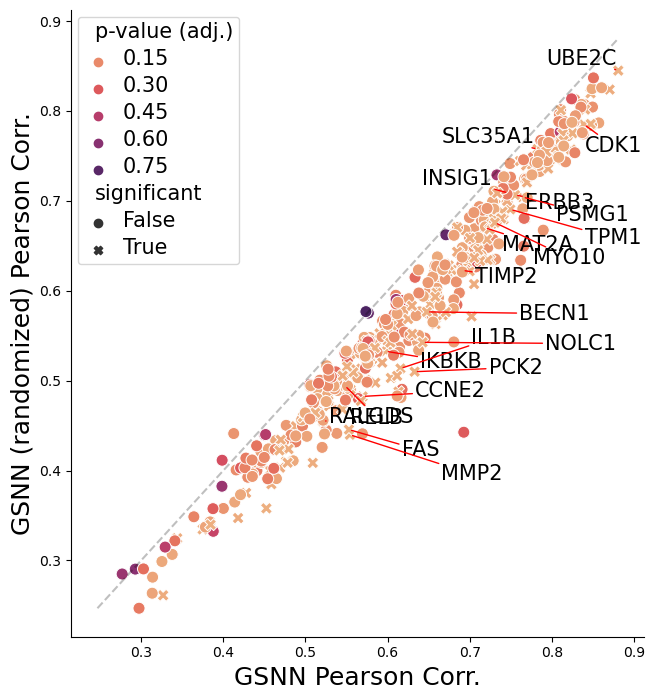

In [16]:
gene_res_rand = grouped_performance({gene:[i] for i,gene in enumerate(data.node_names[data.output_node_mask])}, gsnn_predictions, gsnn_rand_predictions, axis=1, pval_adj_method='fdr_bh', min_members_per_group=0)
gene_res_rand = gene_res_rand.assign(uniprot = [x.split('__')[1] for x in gene_res.group.values])
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
gene_res_rand = gene_res_rand.merge(uni2symb, on='uniprot', how='left')

plot_model2model_comparison(gene_res_rand, 'gene_symbol', 20, model2_name='GSNN (randomized)')

In [17]:
gene_res[['gene_symbol', 'tstat']].to_csv(out_path + '/gene_res_gene_list.csv', index=False, header=False, sep='\t')

# peformance grouped by `target-in-pathway`

e.g., if an observation has a drug with a target in a given pathway... NOTE: this is very different than the next section 

computing row-wise groups
progress: 403/404
# failed groups (too few obs per group): 155


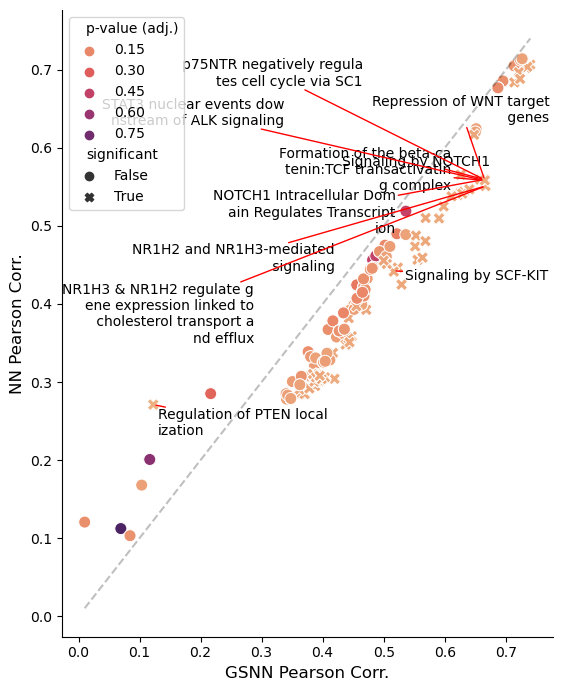

In [18]:
# reactome hiearchy 
dG = nx.from_pandas_edgelist(pd.read_csv('../../data/ReactomePathwaysRelation.txt', sep='\t', header=None).values.T, source=0, target=1, create_using=nx.DiGraph) 
pathspace = [x for x in nx.descendants(dG, 'R-HSA-162582')] # signaling by receptor tyrosine kinases: R-HSA-9006934

# uniprot -> reactome id 
pathways = pd.read_csv('../../data/UniProt2Reactome_All_Levels.txt', sep='\t', header=None)[[0,1,3,5]].rename({0:'uniprot', 1:'reactome_id', 3:'description', 5:'species'}, axis=1)
pathways = pathways[lambda x: x.species == 'Homo sapiens']
pathways = pathways[lambda x: x.reactome_id.isin(pathspace)]

# make groups 
targpath_dict = {} 
targspace = drug_targ.uniprot.unique()
pathspace = pathways.reactome_id.unique()
for path in pathspace: 
    targs_in_pathway = pathways[lambda x: (x.reactome_id == path) & (x.uniprot.isin(targspace))].uniprot.unique()
    drugs_targeting_pathway = drug_targ[lambda x: x.uniprot.isin(targs_in_pathway)].pert_id.values
    obs_with_drug_targ_in_pathway = siginfo2[lambda x: x.pert_id.isin(drugs_targeting_pathway)]
    targpath_dict[path] = obs_with_drug_targ_in_pathway.index.values 

# compute grouped performance 
pathtarg_res = grouped_performance(targpath_dict, gsnn_predictions, nn_predictions, axis=0, pval_adj_method='fdr_by', min_members_per_group=100)
pathtarg_res = pathtarg_res.merge(pathways[['reactome_id', 'description']].drop_duplicates(), left_on='group', right_on='reactome_id', how='left')

plot_model2model_comparison(pathtarg_res.assign(desc2 = lambda x: ['\n'.join(string[i:i+24] for i in range(0, len(string), 24)) for string in x.description]), 'desc2', 10, fontsize=10)

computing row-wise groups
progress: 403/404
# failed groups (too few obs per group): 155


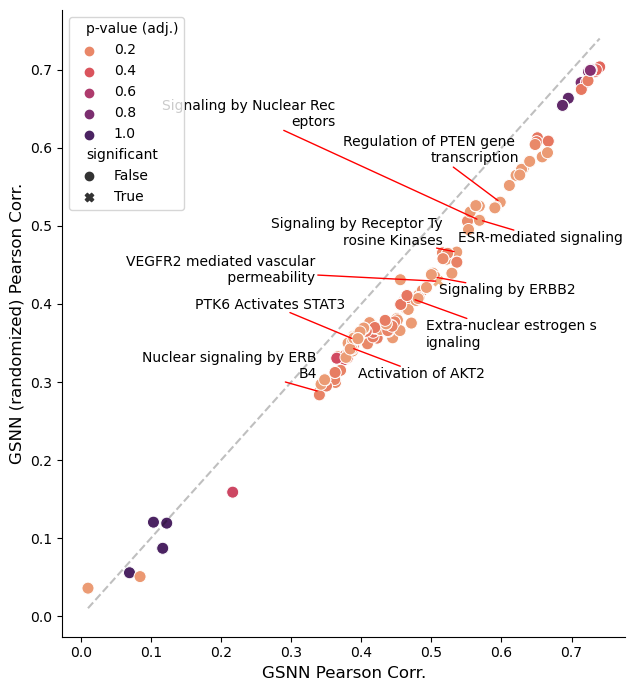

In [19]:
pathtarg_res_rand = grouped_performance(targpath_dict, gsnn_predictions, gsnn_rand_predictions, axis=0, pval_adj_method='fdr_by', min_members_per_group=100)
pathtarg_res_rand = pathtarg_res_rand.merge(pathways[['reactome_id', 'description']].drop_duplicates(), left_on='group', right_on='reactome_id', how='left')

plot_model2model_comparison(pathtarg_res_rand.assign(desc2 = lambda x: ['\n'.join(string[i:i+24] for i in range(0, len(string), 24)) for string in x.description]), 'desc2', 10, fontsize=10, model2_name='GSNN (randomized)')

computing row-wise groups
progress: 403/404
# failed groups (too few obs per group): 155


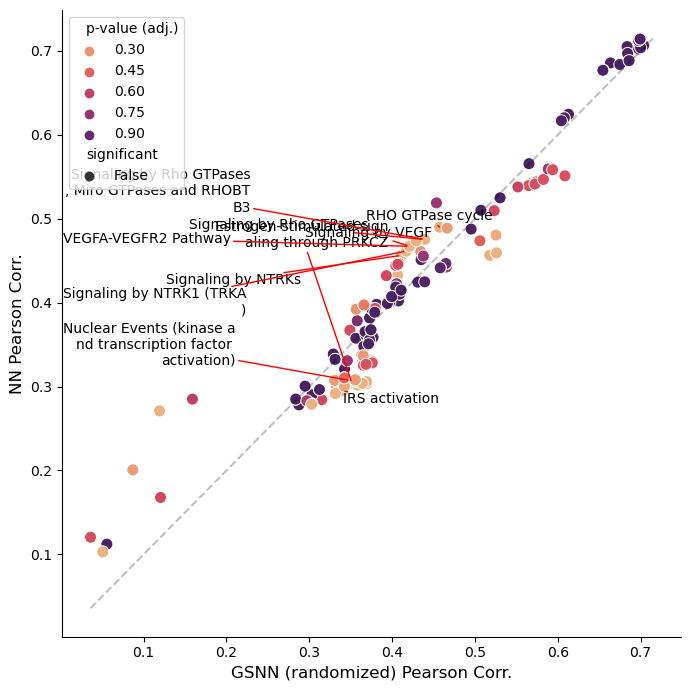

In [37]:
pathtarg_res_rand = grouped_performance(targpath_dict, gsnn_rand_predictions, nn_predictions, axis=0, pval_adj_method='fdr_by', min_members_per_group=100)
pathtarg_res_rand = pathtarg_res_rand.merge(pathways[['reactome_id', 'description']].drop_duplicates(), left_on='group', right_on='reactome_id', how='left')

plot_model2model_comparison(pathtarg_res_rand.assign(desc2 = lambda x: ['\n'.join(string[i:i+24] for i in range(0, len(string), 24)) for string in x.description]), 'desc2', 10, fontsize=10, model1_name='GSNN (randomized)')

In [20]:
pathtarg_res_rand.sort_values(by='tstat', ascending=False).head(15)

,group,gsnn_mean_r,nn_mean_r,gsnn_std_r,nn_std_r,pval,tstat,mean_diff_r,std_diff_r,ci_diff_r,N_members,pval_adj,reactome_id,description
159,R-HSA-5218920,0.510190,0.429097,0.001810,0.001976,0.000026,194.610026,0.081093,0.000589,"[0.08032451167084328, 0.08159374504108582]",7192,0.040082,R-HSA-5218920,VEGFR2 mediated vascular permeability
109,R-HSA-8849474,0.390251,0.354531,0.011177,0.011686,0.000366,52.259851,0.035720,0.000967,"[0.03502617049886265, 0.0369846409070119]",2188,0.118643,R-HSA-8849474,PTK6 Activates STAT3
94,R-HSA-1227986,0.504267,0.434542,0.000824,0.001313,0.000448,47.231020,0.069724,0.002088,"[0.0669916817714353, 0.07138112297393075]",10743,0.118643,R-HSA-1227986,Signaling by ERBB2
51,R-HSA-8939211,0.569144,0.507641,0.003388,0.005050,0.000449,47.164355,0.061503,0.001844,"[0.059088638821670765, 0.0628533831489716]",17328,0.118643,R-HSA-8939211,ESR-mediated signaling
52,R-HSA-9006931,0.568663,0.507214,0.003384,0.005048,0.000451,47.074583,0.061449,0.001846,"[0.05903204677409889, 0.06280106726624372]",17383,0.118643,R-HSA-9006931,Signaling by Nuclear Receptors
68,R-HSA-8943724,0.598250,0.530408,0.006362,0.009151,0.000845,34.386913,0.067842,0.002790,"[0.0641916660239228, 0.07007883658570133]",9156,0.118643,R-HSA-8943724,Regulation of PTEN gene transcription
98,R-HSA-1251985,0.340773,0.287524,0.006364,0.008264,0.001292,27.790642,0.053249,0.002710,"[0.05105058958686263, 0.056793102876701425]",4865,0.118643,R-HSA-1251985,Nuclear signaling by ERBB4
53,R-HSA-9009391,0.472987,0.406587,0.003104,0.001257,0.001299,27.719253,0.066400,0.003388,"[0.06197949607330452, 0.06926247881862534]",14805,0.118643,R-HSA-9009391,Extra-nuclear estrogen signaling
43,R-HSA-9006934,0.536236,0.466504,0.001723,0.005224,0.001309,27.615961,0.069732,0.003571,"[0.06551222730737997, 0.07381790051545323]",28927,0.118643,R-HSA-9006934,Signaling by Receptor Tyrosine Kinases
157,R-HSA-165158,0.385562,0.344012,0.011848,0.012094,0.001428,26.430465,0.041551,0.002223,"[0.03877268411091251, 0.04386931177628108]",2535,0.118643,R-HSA-165158,Activation of AKT2


In [21]:
path_res2 = {'reactome_id':[], 'prop_proteins':[], 'prop_rnas':[], 'prop_lincs':[], 'prop_targs':[], 'path_size':[]}

GSNN_proteins = [x.split('__')[1] for x in data.node_names if 'PROTEIN__' in x]
GSNN_rnas = [x.split('__')[1] for x in data.node_names if 'RNA__' in x]
GSNN_lincs = [x.split('__')[1] for x in data.node_names if 'LINCS__' in x]

for i,path in enumerate(pathspace): 
    print(f'progress: {i}/{len(pathspace)}', end='\r')
    tmp = pathways[lambda x: x.reactome_id == path]
    full_pathway = set(tmp.uniprot.unique().tolist()) 
    prots_in_pathway = set(GSNN_proteins).intersection(full_pathway)
    rnas_in_pathway = set(GSNN_rnas).intersection(full_pathway)
    lincs_in_pathway = set(GSNN_lincs).intersection(full_pathway)
    targs_in_pathway = set(targspace).intersection(full_pathway)

    path_res2['reactome_id'].append(path)
    path_res2['prop_proteins'].append(len(prots_in_pathway) / len(full_pathway))
    path_res2['prop_rnas'].append(len(rnas_in_pathway) / len(full_pathway))
    path_res2['prop_lincs'].append(len(lincs_in_pathway) / len(full_pathway))
    path_res2['prop_targs'].append(len(targs_in_pathway) / len(full_pathway))
    path_res2['path_size'].append(len(full_pathway))

path_res2 = pd.DataFrame(path_res2)
path_res2.head()

,reactome_id,prop_proteins,prop_rnas,prop_lincs,prop_targs,path_size
0,R-HSA-194315,0.096012,0.097489,0.056130,0.025111,677
1,R-HSA-9012999,0.079646,0.070796,0.042035,0.017699,452
2,R-HSA-9013106,0.080000,0.080000,0.040000,0.013333,75
3,R-HSA-9716542,0.093795,0.095238,0.054834,0.024531,693
4,R-HSA-9696270,0.116279,0.093023,0.023256,0.000000,43


In [22]:
pathtarg_res2 = pathtarg_res.merge(path_res2, on='reactome_id')

In [23]:
pathtarg_res2[['mean_diff_r', 'tstat', 'prop_proteins', 'prop_lincs', 'prop_rnas', 'prop_targs']].corr('pearson')

,mean_diff_r,tstat,prop_proteins,prop_lincs,prop_rnas,prop_targs
mean_diff_r,1.000000,0.577739,-0.014439,0.126683,0.180542,0.005458
tstat,0.577739,1.000000,-0.103307,0.021718,-0.054262,-0.042254
prop_proteins,-0.014439,-0.103307,1.000000,0.157999,0.614487,0.679177
prop_lincs,0.126683,0.021718,0.157999,1.000000,0.597542,0.229149
prop_rnas,0.180542,-0.054262,0.614487,0.597542,1.000000,0.598530
prop_targs,0.005458,-0.042254,0.679177,0.229149,0.598530,1.000000


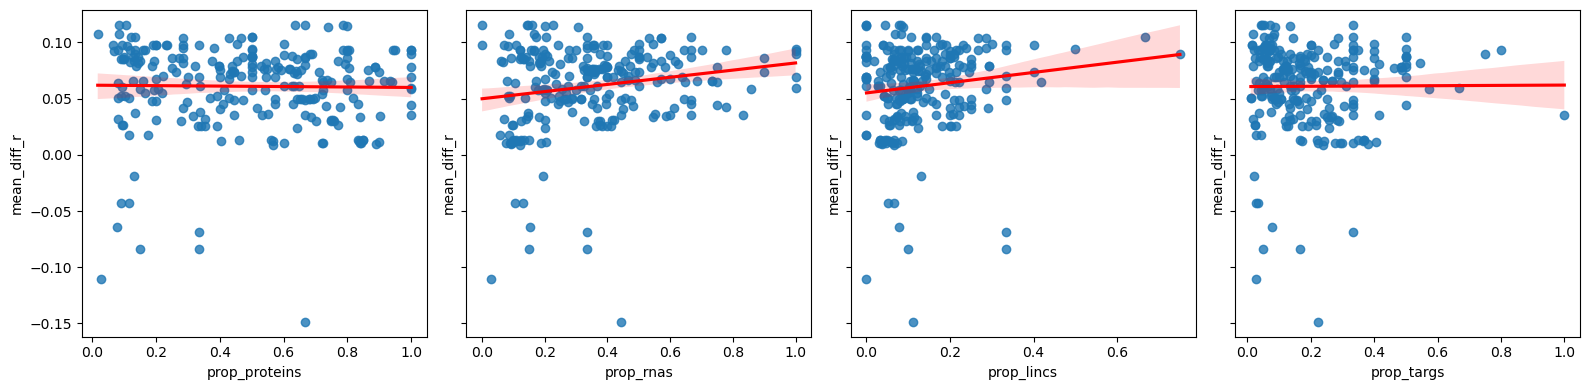

In [24]:
__metric__ = 'mean_diff_r'
f, axes = plt.subplots(1,4,figsize=(4*4, 4), sharey=True)
sbn.regplot(x='prop_proteins', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[0])
sbn.regplot(x='prop_rnas', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[1])
sbn.regplot(x='prop_lincs', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[2])
sbn.regplot(x='prop_targs', y=__metric__, data=pathtarg_res2, line_kws={'color':'r'}, ax=axes.flat[3])
#plt.xlabel('proportion of LINCS genes (in GSNN) in pathway')
#plt.ylabel('GSNN prediction advantage (diff. in corr.)')
plt.tight_layout()
plt.show()

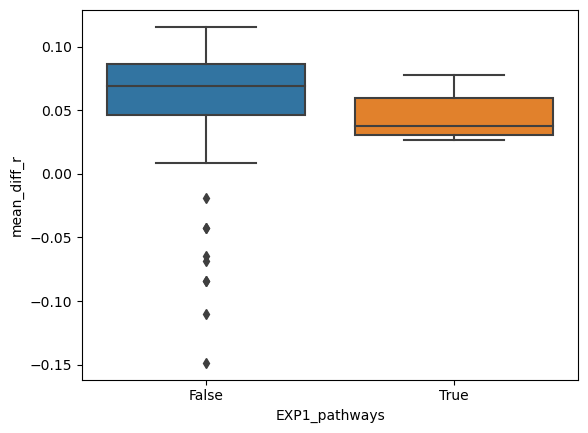

In [25]:
pathtarg_res2 = pathtarg_res2.assign(EXP1_pathways = lambda x: x.group.isin('R-HSA-177929 R-HSA-1489509 R-HSA-1257604 R-HSA-5673001 R-HSA-1227986 R-HSA-109606 R-HSA-6806003 R-HSA-202131 R-HSA-6807070 R-HSA-6807070 R-HSA-5673001'.split(' ')))

plt.figure()
sbn.boxplot(x='EXP1_pathways', y='mean_diff_r', data=pathtarg_res2)
plt.show()

# performance by `cell line`

computing row-wise groups
progress: 79/80
# failed groups (too few obs per group): 18


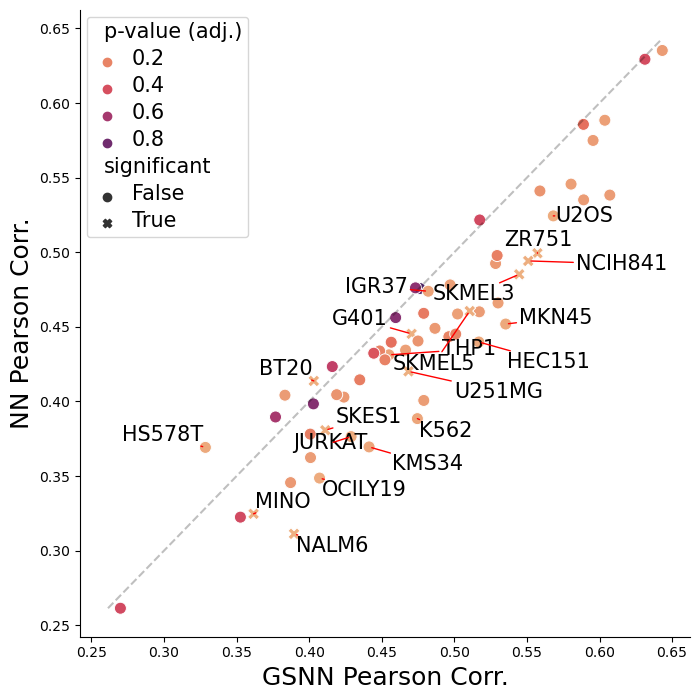

In [26]:
cell_dict = {} 
cellspace = siginfo2.cell_iname.unique()
for i, cell in enumerate(cellspace): 
    cell_dict[cell] = siginfo2[lambda x: x.cell_iname == cell].index.values 

cell_res = grouped_performance(cell_dict, gsnn_predictions, nn_predictions, min_members_per_group=100)
plot_model2model_comparison(cell_res, 'group', 20)
   

computing row-wise groups
progress: 79/80
# failed groups (too few obs per group): 0


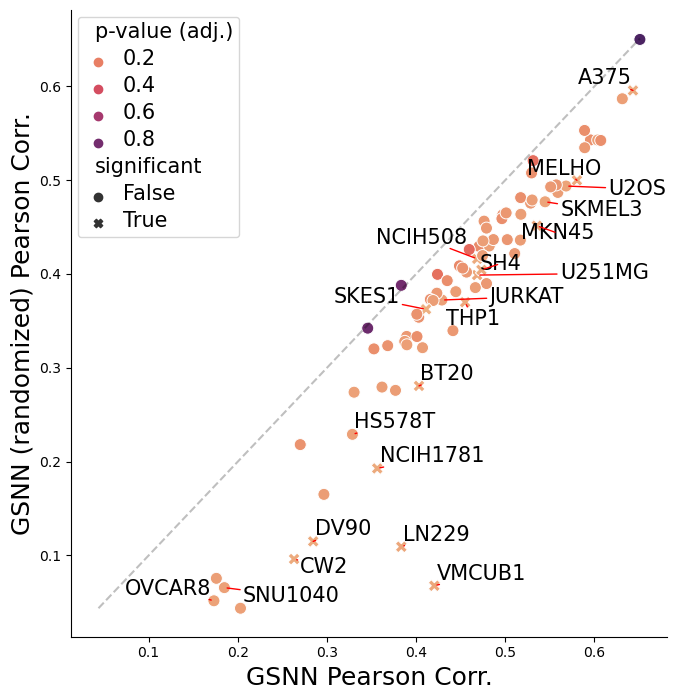

In [27]:
cell_res_rand = grouped_performance(cell_dict, gsnn_predictions, gsnn_rand_predictions)
plot_model2model_comparison(cell_res_rand, 'group', 20, model2_name='GSNN (randomized)')

# performance by `disease`

computing row-wise groups
progress: 26/27
# failed groups (too few obs per group): 8


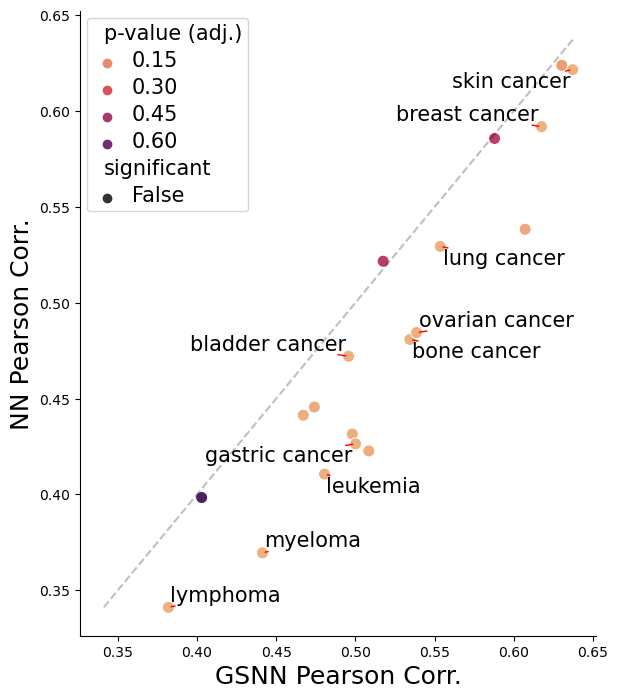

In [28]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')

dis_dict = {} 
disspace = cellinfo.primary_disease.unique()
for i, dis in enumerate(disspace): 
    print(f'progress: {i}/{len(disspace)}', end='\r')
    cells_in_disease = cellinfo[lambda x: x.primary_disease == dis].cell_iname.unique()
    dis_dict[dis] = siginfo2[lambda x: x.cell_iname.isin(cells_in_disease)].index.values

dis_res = grouped_performance(dis_dict, gsnn_predictions, nn_predictions, min_members_per_group=100, pval_adj_method='fdr_bh')
plot_model2model_comparison(dis_res, 'group', 10)


computing row-wise groups
progress: 26/27
# failed groups (too few obs per group): 8


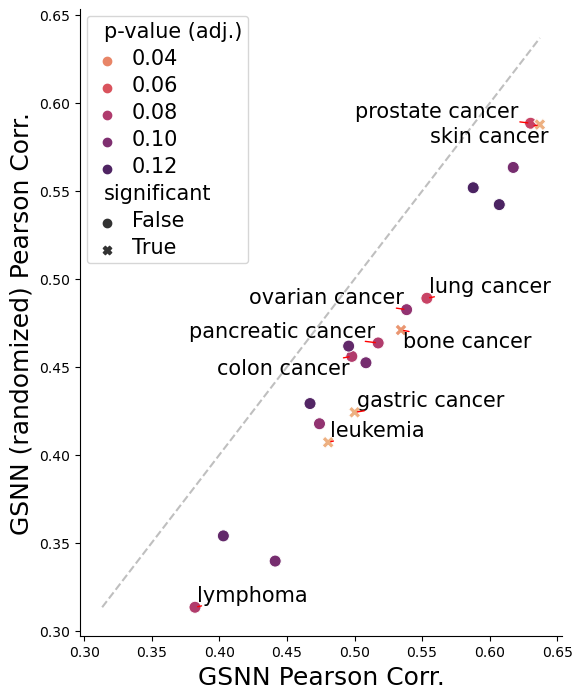

In [29]:
dis_res_rand = grouped_performance(dis_dict, gsnn_predictions, gsnn_rand_predictions, min_members_per_group=100)
plot_model2model_comparison(dis_res_rand, 'group', 10, model2_name='GSNN (randomized)')

# Performance grouped by `dose`

computing row-wise groups
progress: 46/47
# failed groups (too few obs per group): 30


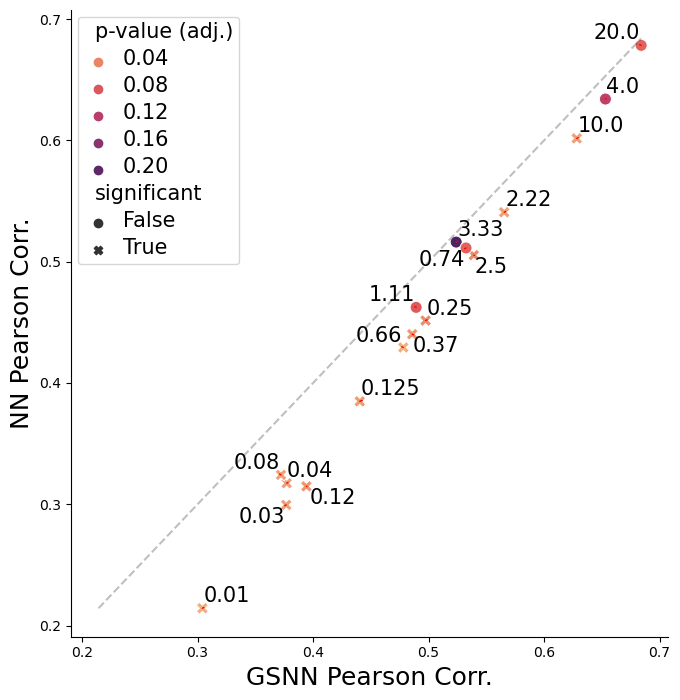

In [30]:
#dose_dict = {str(c):siginfo2[lambda x: x.pert_dose == c].index.values for c in siginfo2.pert_dose.unique()}
dose_dict = {str(c):siginfo2[lambda x: x.nearest_dose == c].index.values for c in siginfo2.nearest_dose.unique()}

dose_res = grouped_performance(dose_dict, gsnn_predictions, nn_predictions, axis=0, min_members_per_group=100, pval_adj_method='fdr_bh')
plot_model2model_comparison(dose_res, 'group', 25)

computing row-wise groups
progress: 46/47
# failed groups (too few obs per group): 30


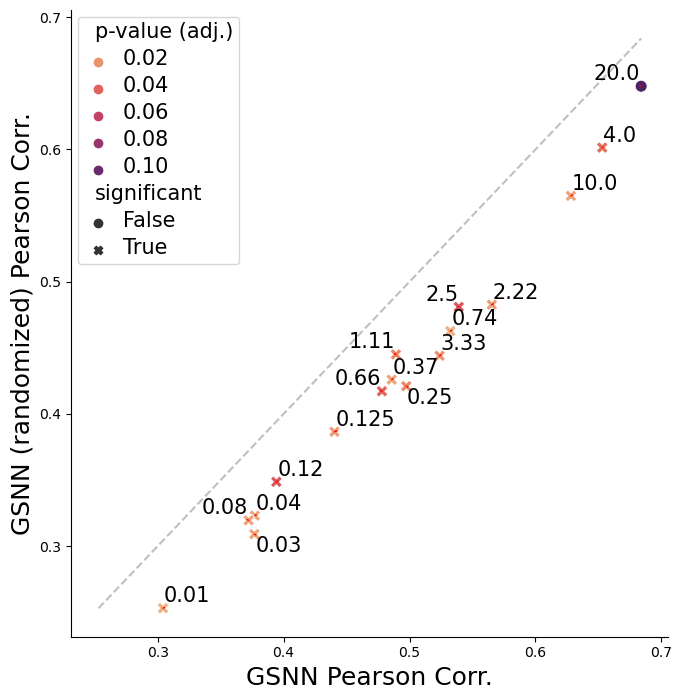

In [31]:
dose_res_rand = grouped_performance(dose_dict, gsnn_predictions, gsnn_rand_predictions, axis=0, min_members_per_group=100, pval_adj_method='fdr_bh')
plot_model2model_comparison(dose_res_rand, 'group', 25, model2_name='GSNN (randomized)')

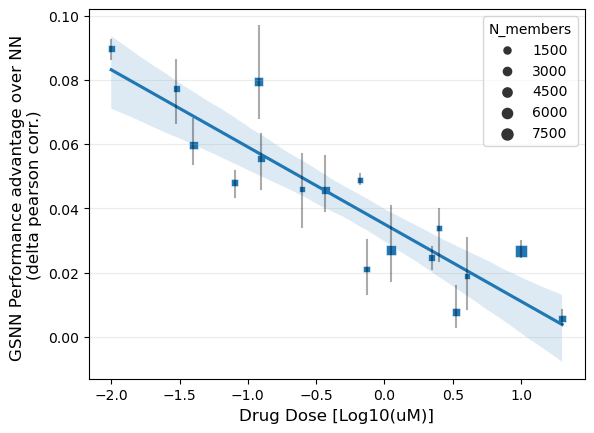

In [39]:
result = sm.ols(formula="mean_diff_r ~  log_dose", data=dose_res.assign(log_dose = [np.log10(float(x)) for x in dose_res.group.values])).fit()

plt.figure()
sbn.regplot(x='log_dose', 
            y='mean_diff_r', 
            data=dose_res.assign(log_dose = [np.log10(float(x)) for x in dose_res.group.values]), 
            scatter=False)

#scatter_kws={'color':'k', 's':[np.sqrt(x) for x in dose_res.N_members.values], 'marker':11}, 
#label=f'log10(dose) p-value: {result.pvalues.log_dose:.2E}\nr-squared: {result.rsquared:.2f}') 

for i,row in dose_res.iterrows(): 
    plt.plot((np.log10(float(row.group)), np.log10(float(row.group))), ( row.ci_diff_r[0], row.ci_diff_r[1]), 'k-', alpha=0.33)

sbn.scatterplot(x='log_dose', 
                y='mean_diff_r', 
                marker='s',
                size='N_members',
                s=50,
                data=dose_res.assign(log_dose = [np.log10(float(x)) for x in dose_res.group.values], 
                                     log_N = [np.log10(float(x)) for x in dose_res.N_members.values]), alpha=1.)

plt.xlabel('Drug Dose [Log10(uM)]', fontsize=12)
plt.ylabel('GSNN Performance advantage over NN \n(delta pearson corr.)', fontsize=12)
plt.grid(which='major', axis='y', zorder=-1.0, alpha=0.25)
plt.show()

# Perfromance grouped by `metastis`

computing row-wise groups
progress: 3/4
# failed groups (too few obs per group): 0


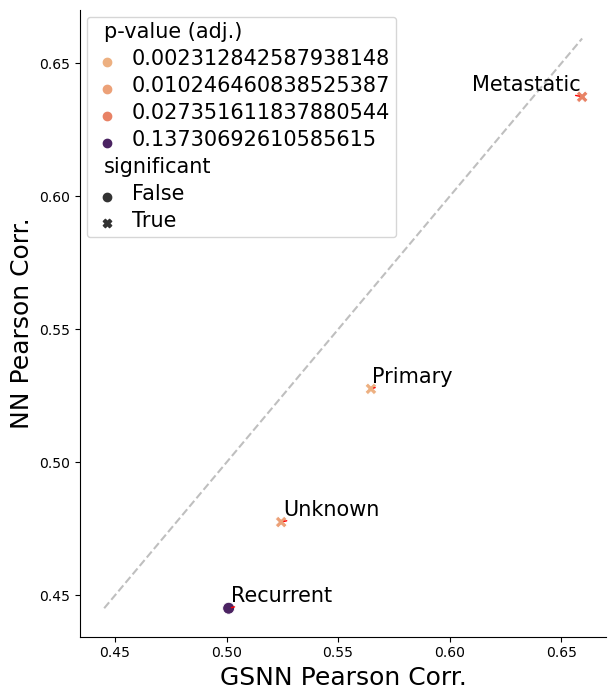

In [33]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')

met_dict = {} 
metspace = cellinfo.donor_tumor_phase.unique()
for i, dis in enumerate(metspace): 
    print(f'progress: {i}/{len(metspace)}', end='\r')
    cells_in_phase = cellinfo[lambda x: x.donor_tumor_phase == dis].cell_iname.unique()
    met_dict[dis] = siginfo2[lambda x: x.cell_iname.isin(cells_in_phase)].index.values

met_res = grouped_performance(met_dict, gsnn_predictions, nn_predictions, min_members_per_group=100, pval_adj_method='fdr_bh')
plot_model2model_comparison(met_res, 'group', 10)

computing row-wise groups
progress: 2/3
# failed groups (too few obs per group): 0


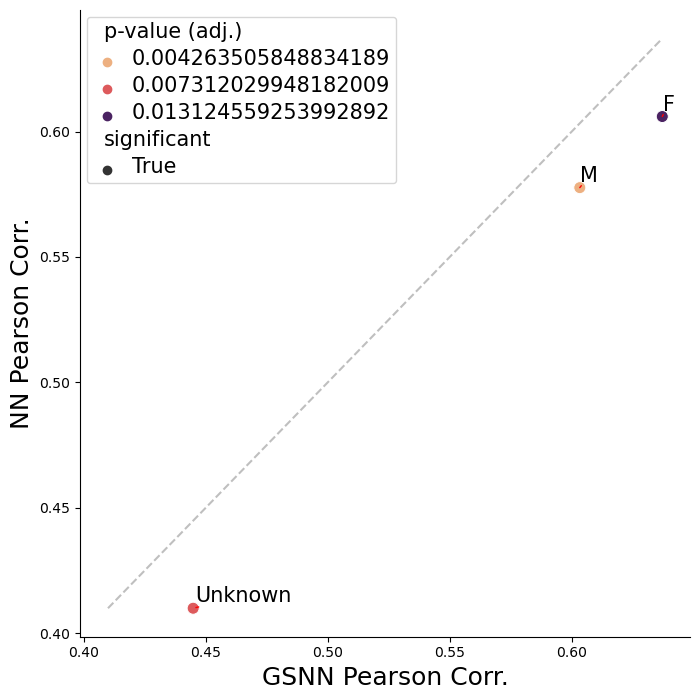

In [34]:
cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')

met_dict = {} 
metspace = cellinfo.donor_sex.unique()
for i, dis in enumerate(metspace): 
    print(f'progress: {i}/{len(metspace)}', end='\r')
    cells_in_phase = cellinfo[lambda x: x.donor_sex == dis].cell_iname.unique()
    met_dict[dis] = siginfo2[lambda x: x.cell_iname.isin(cells_in_phase)].index.values

met_res = grouped_performance(met_dict, gsnn_predictions, nn_predictions, min_members_per_group=0, pval_adj_method='fdr_bh')
plot_model2model_comparison(met_res, 'group', 10)

In [35]:
cellinfo.head()

,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,1HAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal fibroblast sample,NaN,unknown,NaN,NaN
1,AALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal epithelium sample,NaN,unknown,NaN,NaN
2,AG06263_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
3,AG06840_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
4,AG078N1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN


In [36]:
cellinfo.cell_type.unique()

array(['normal', 'tumor', 'pool'], dtype=object)